In [ ]:
pip install pandas sentence-transformers faiss-cpu scikit-learn transformers torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 81.1 MB/s eta 0:00:00


In [ ]:
pip install transformers datasets accelerate torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import pandas as pd
import numpy as np
# Load the datasets
df_2023 = pd.read_csv('survey_results_public2023.csv').drop(['ResponseId'], axis=1).drop_duplicates()
df_2024 = pd.read_csv('survey_results_public2024.csv').drop(['ResponseId'], axis=1).drop_duplicates()

#Add columns for specific years
df_2023['Year'] = 2023
df_2024['Year'] = 2024

In [ ]:
# Rename AIAcc to AIBen and AIBen to AIAcc
df_2023 = df_2023.rename(columns={'AIAcc': 'Temp', 'AIBen': 'AIAcc'})
df_2023 = df_2023.rename(columns={'Temp': 'AIBen'})

In [ ]:
# Add AIThreat and AIChallenge column to 2023
df_2023['AIThreat'] = np.nan
df_2023['AIChallenge'] = np.nan

In [ ]:
# Rename specific columns
df_2024 = df_2024.rename(columns={
    'AINextMuch less integrated': 'AINextVery different',
    'AINextLess integrated': 'AINextSomewhat different',
    'AINextMore integrated': 'AINextSomewhat similar',
    'AINextMuch more integrated': 'AINextVery similar',
    'AINextNo change': 'AINextNeither different nor similar'

})

In [ ]:
# Merge AIDevHaveWorkedWith and AISearchHaveWorkedWith to AISearchDevHaveWorkedWith
df_2023['AISearchDevHaveWorkedWith'] = df_2023['AIDevHaveWorkedWith'].astype(str) + ";" + df_2023['AISearchHaveWorkedWith'].astype(str)
df_2023['AISearchDevWantToWorkWith'] = df_2023['AIDevWantToWorkWith'].astype(str) + ";" + df_2023['AISearchWantToWorkWith'].astype(str)


In [ ]:
df_2023.shape

(87981, 88)

In [ ]:
df_2024.shape

(64950, 114)

In [ ]:
# Merge the datasets
data = pd.concat([df_2023, df_2024])

In [ ]:
data.shape

(152931, 123)

In [ ]:
df = data.copy()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import faiss
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
import json
import random


# Step 1: Text Embedding Preparation
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine all specified text features into a single string per row
text_features = [
    "AISearchDevHaveWorkedWith", "AISearchDevWantToWorkWith", "AISelect",
    "AISent", "AIAcc", "AIBen", "AIToolInterested in Using", "AIToolCurrently Using",
    "AIToolNot interested in Using", "AINextVery different",
    "AINextNeither different nor similar", "AINextSomewhat similar",
    "AINextVery similar", "AINextSomewhat different", 'DevType', 'PlatformWantToWorkWith',
    'Industry', 'LanguageWantToWorkWith', 'ToolsTechWantToWorkWith',
    "LanguageHaveWorkedWith", "LanguageWantToWorkWith", "DatabaseHaveWorkedWith",
    "DatabaseWantToWorkWith", "PlatformHaveWorkedWith", "PlatformWantToWorkWith",
    "WebframeHaveWorkedWith", "WebframeWantToWorkWith", "MiscTechHaveWorkedWith",
    "MiscTechWantToWorkWith", "ToolsTechHaveWorkedWith", "ToolsTechWantToWorkWith",
    "NEWCollabToolsHaveWorkedWith", "NEWCollabToolsWantToWorkWith",
    "OpSysPersonal use", "OpSysProfessional use", "OfficeStackAsyncHaveWorkedWith",
    "OfficeStackAsyncWantToWorkWith", "OfficeStackSyncHaveWorkedWith",
    "OfficeStackSyncWantToWorkWith", "Employment", "OrgSize", "RemoteWork", "SOVisitFreq",
    "SOAccount", "SOPartFreq", "SOComm", "NEWSOSites"
]
df['combined_text_features'] = df[text_features].astype(str).fillna('').agg(' '.join, axis=1)

# Generate embeddings for the combined text features
text_embeddings = embedding_model.encode(df['combined_text_features'].tolist())

# Step 2: Numerical Features Normalization
numerical_features = [
    'WorkExp', 'YearsCode', 'ConvertedCompYearly', 'YearsCodePro'
]

#Handle errors if any arise
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

scaler = StandardScaler()
numerical_embeddings = scaler.fit_transform(df[numerical_features].fillna(0).values)

# Step 3: Combine Text and Numerical Embeddings
row_embeddings = np.hstack((text_embeddings, numerical_embeddings))

# Step 4: Create FAISS Index
dimension = row_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(row_embeddings)

# Step 5: Function to Retrieve Relevant Context
def retrieve_context(query, top_k=3, experience_value=5):
    # Convert query into text and numerical embeddings
    query_text_embedding = embedding_model.encode([query])
    query_num_features = np.array([[experience_value, 0, 0, 0]])  # Replace with relevant inputs
    query_num_scaled = scaler.transform(query_num_features)

    # Combine text and numerical embeddings
    query_embedding = np.hstack((query_text_embedding, query_num_scaled))

    # Perform FAISS search
    distances, indices = faiss_index.search(query_embedding, top_k)

    # Retrieve rows and combine job roles as context
    retrieved_rows = df.iloc[indices[0]]
    context = " ".join(retrieved_rows['DevType'].tolist())  # Adjust as needed
    return context

# Step 6: Fine-Tuning the Model
# Save the training data to a JSONL file
import random
import json

# Sample queries and contexts
queries = [
    "AI in healthcare", "AI in finance", "Cloud computing", "Blockchain in supply chain",
    "Green technology", "Quantum computing", "Cybersecurity in IoT", "AI in retail",
    "Space technology", "Autonomous vehicles"
]

contexts = [
    "Data Scientist, Machine Learning Engineer",
    "Cloud Engineer, Software Developer",
    "Blockchain Developer, Supply Chain Manager",
    "Environmental Scientist, Renewable Energy Engineer",
    "Quantum Physicist, Algorithm Designer",
    "Security Analyst, IoT Specialist",
    "Retail Analyst, Robotics Engineer",
    "Aerospace Engineer, Satellite Designer",
    "Autonomous Systems Engineer, Automotive Engineer"
]

roles = [
    "AI Healthcare Strategist", "Cloud Automation Engineer", "Blockchain System Architect",
    "Sustainable Tech Consultant", "Quantum AI Researcher", "IoT Cybersecurity Specialist",
    "Retail Data Scientist", "Space Exploration Analyst", "Autonomous Vehicle Programmer"
]

# Generate examples
examples = []
for _ in range(10000):
    query = random.choice(queries)
    context = random.choice(contexts)
    generated_roles = ", ".join(random.sample(roles, 2))  # Select 2 random roles
    example = {
        "prompt": f"Query: {query}\nContext: {context}\nPropose job roles:",
        "response": generated_roles
    }
    examples.append(example)

# Save to JSONL file
with open("training_data.jsonl", "w") as f:
    for example in examples:
        f.write(json.dumps(example) + "\n")


# Load the dataset
dataset = load_dataset("json", data_files={"train": "training_data.jsonl"})

# Load Pre-trained GPT-2 Model and Tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)

# Tokenize Dataset
def tokenize_function(examples):
    tokens = tokenizer(
        examples["prompt"],  # Tokenize prompts
        text_pair=examples["response"],  # Tokenize paired responses
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    tokens["labels"] = tokens["input_ids"].copy()  # Use input_ids as labels
    return tokens

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Fine-Tuning Arguments
# training_args = TrainingArguments(
#     output_dir="./fine_tuned_gpt2",
#     evaluation_strategy="no",
#     learning_rate=5e-5,
#     num_train_epochs=3,
#     per_device_train_batch_size=2,
#     save_steps=10_000,
#     save_total_limit=2,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     report_to="none",
# )

training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",
    evaluation_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    max_steps=1000,  # Total number of training steps
    save_steps=500,  # Save the model every 500 steps
    save_total_limit=2,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
)

# Train the Model
trainer.train()

# Save Fine-Tuned Model
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

# Step 7: Use the Fine-Tuned Model for Predictions
generator = pipeline("text-generation", model="./fine_tuned_gpt2", tokenizer=tokenizer, device=0)

# Function: Predict New Job Roles
def predict_new_job_roles(query):
    # Retrieve context
    context = retrieve_context(query)

    # Combine query and context into a prompt
    input_prompt = (
        f"Query: {query}\n"
        f"Existing roles and trends: {context}\n"
        "Propose entirely new job roles based on emerging technologies and future trends:"
    )

    # Generate predictions
    response = generator(input_prompt, max_length=100, num_return_sequences=3)
    return [r['generated_text'] for r in response]

# Example Usage
query = "AI in finance"
predictions = predict_new_job_roles(query)
print(predictions)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
500,0.060700
1000,0.018700


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['Query: AI in finance\nExisting roles and trends: Developer, AI Data scientist or machine learning specialist System administrator\nPropose entirely new job roles based on emerging technologies and future trends:Blockchain System Architect, Blockchain System Architect', 'Query: AI in finance\nExisting roles and trends: Developer, AI Data scientist or machine learning specialist System administrator\nPropose entirely new job roles based on emerging technologies and future trends:Blockchain System Architect, Blockchain System Architect', 'Query: AI in finance\nExisting roles and trends: Developer, AI Data scientist or machine learning specialist System administrator\nPropose entirely new job roles based on emerging technologies and future trends:Quantum AI Researcher, Cloud Automation Engineer']


In [ ]:
# Example Usage
query = "Python 4 years experience in java worked with atom"
predictions = predict_new_job_roles(query)
print(predictions)

['Query: Python 4 years experience in java worked with atom\nExisting roles and trends: Designer Developer, full-stack Blockchain\nPropose entirely new job roles based on emerging technologies and future trends:Retail Data Scientist, Cloud Automation Engineer', 'Query: Python 4 years experience in java worked with atom\nExisting roles and trends: Designer Developer, full-stack Blockchain\nPropose entirely new job roles based on emerging technologies and future trends:AI Healthcare Strategist, Blockchain System Architect', 'Query: Python 4 years experience in java worked with atom\nExisting roles and trends: Designer Developer, full-stack Blockchain\nPropose entirely new job roles based on emerging technologies and future trends:AI Healthcare Strategist, Blockchain System Architect']


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fef8298674c238010926f0aede155ed63fb6a6ff6acbb79a0800f42ff3a3ce2d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
import random
import json
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, pipeline
from nltk.translate.bleu_score import sentence_bleu
# from rouge import Rouge
import torch

# Step 1: Prepare Dataset
# Define queries and roles for creating the dataset
queries = [
    "AI in healthcare", "AI in finance", "Cloud computing", "Blockchain in supply chain",
    "Green technology", "Quantum computing", "Cybersecurity in IoT", "AI in retail",
    "Space technology", "Autonomous vehicles"
]

roles = [
    "AI Healthcare Strategist", "Cloud Automation Engineer", "Blockchain System Architect",
    "Sustainable Tech Consultant", "Quantum AI Researcher", "IoT Cybersecurity Specialist",
    "Retail Data Scientist", "Space Exploration Analyst", "Autonomous Vehicle Programmer"
]

# Generate dataset
examples = []
for _ in range(1000):  # Adjust size as needed
    query = random.choice(queries)
    generated_roles = ", ".join(random.sample(roles, 2))  # Select 2 random roles
    examples.append({
        "prompt": f"Query: {query}\nPropose job roles:",
        "response": generated_roles
    })

# Split into training and testing datasets (80% train, 20% test)
random.shuffle(examples)
train_size = int(0.8 * len(examples))
train_data = examples[:train_size]
test_data = examples[train_size:]

# Save datasets to JSONL files
with open("training_data.jsonl", "w") as f:
    for example in train_data:
        f.write(json.dumps(example) + "\n")

with open("testing_data.jsonl", "w") as f:
    for example in test_data:
        f.write(json.dumps(example) + "\n")

# Step 2: Load Training and Testing Data
train_dataset = load_dataset("json", data_files={"train": "training_data.jsonl"})["train"]
test_dataset = load_dataset("json", data_files={"test": "testing_data.jsonl"})["test"]

# Step 3: Load Pretrained Model and Tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Step 4: Tokenize Data
def tokenize_function(examples):
    tokens = tokenizer(
        examples["prompt"],
        text_pair=examples["response"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    tokens["labels"] = tokens["input_ids"].copy()  # Use input_ids as labels
    return tokens

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Step 5: Fine-Tune the Model
training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",
    evaluation_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    # max_steps=1000,  # Adjust as needed
    save_steps=500,
    save_total_limit=2,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
)

# Train the Model
trainer.train()

# Save Fine-Tuned Model
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

# Step 6: Evaluate Model on Test Data
generator = pipeline("text-generation", model="./fine_tuned_gpt2", tokenizer=tokenizer, device=0)

# Generate predictions for test dataset
predictions = []
for example in test_dataset:
    prompt = example["prompt"]
    generated = generator(prompt, max_new_tokens=50, num_return_sequences=1)
    predictions.append({
        "query": prompt,
        "expected": example["response"],
        "generated": generated[0]["generated_text"]
    })

# Step 7: Calculate Accuracy Metrics
# BLEU Score
for result in predictions:
    generated_roles = result["generated"].split(", ")  # Split generated roles
    expected_roles = [result["expected"].split(", ")]  # Wrap in list for BLEU
    bleu_score = sentence_bleu(expected_roles, generated_roles)
    result["bleu_score"] = bleu_score

# ROUGE Score
# rouge = Rouge()
# for result in predictions:
#     rouge_scores = rouge.get_scores(result["generated"], result["expected"], avg=True)
#     result["rouge_score"] = rouge_scores

# Display Evaluation Results
for result in predictions[:10]:  # Show a sample of results
    print(f"Query: {result['query']}")
    print(f"Expected: {result['expected']}")
    print(f"Generated: {result['generated']}")
    print(f"BLEU Score: {result['bleu_score']:.2f}")
    # print(f"ROUGE Scores: {result['rouge_score']}")
    print("---")


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
500,0.056200
1000,0.013900


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Query: Query: Autonomous vehicles
Propose job roles:
Expected: Retail Data Scientist, Autonomous Vehicle Programmer
Generated: Query: Autonomous vehicles
Propose job roles:Autonomous Vehicle Programmer, Blockchain System Architect
BLEU Score: 0.00
---
Query: Query: Space technology
Propose job roles:
Expected: Autonomous Vehicle Programmer, Sustainable Tech Consultant
Generated: Query: Space technology
Propose job roles:Autonomous Vehicle Programmer, IoT Cybersecurity Specialist
BLEU Score: 0.00
---
Query: Query: AI in retail
Propose job roles:
Expected: Cloud Automation Engineer, AI Healthcare Strategist
Generated: Query: AI in retail
Propose job roles:Blockchain System Architect, Retail Data Scientist
BLEU Score: 0.00
---
Query: Query: Cloud computing
Propose job roles:
Expected: Space Exploration Analyst, AI Healthcare Strategist
Generated: Query: Cloud computing
Propose job roles:Sustainable Tech Consultant, Retail Data Scientist
BLEU Score: 0.00
---
Query: Query: Autonomous vehicl

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Initialize embedding model (SentenceTransformer)
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to calculate cosine similarity between two texts
def cosine_similarity_score(text1, text2):
    embeddings1 = embedding_model.encode([text1])
    embeddings2 = embedding_model.encode([text2])
    similarity = cosine_similarity(embeddings1, embeddings2)
    return similarity[0][0]

# Evaluate using cosine similarity
for result in predictions:
    expected_roles = result["expected"]
    generated_roles = result["generated"]

    # Calculate the cosine similarity score for generated vs expected roles
    similarity = cosine_similarity_score(expected_roles, generated_roles)
    result["cosine_similarity"] = similarity

    print(f"Query: {result['query']}")
    print(f"Expected: {expected_roles}")
    print(f"Generated: {generated_roles}")
    print(f"Cosine Similarity: {similarity:.2f}")
    print("---")



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Query: Query: Autonomous vehicles
Propose job roles:
Expected: Retail Data Scientist, Autonomous Vehicle Programmer
Generated: Query: Autonomous vehicles
Propose job roles:Autonomous Vehicle Programmer, Blockchain System Architect
Cosine Similarity: 0.62
---
Query: Query: Space technology
Propose job roles:
Expected: Autonomous Vehicle Programmer, Sustainable Tech Consultant
Generated: Query: Space technology
Propose job roles:Autonomous Vehicle Programmer, IoT Cybersecurity Specialist
Cosine Similarity: 0.58
---
Query: Query: AI in retail
Propose job roles:
Expected: Cloud Automation Engineer, AI Healthcare Strategist
Generated: Query: AI in retail
Propose job roles:Blockchain System Architect, Retail Data Scientist
Cosine Similarity: 0.45
---
Query: Query: Cloud computing
Propose job roles:
Expected: Space Exploration Analyst, AI Healthcare Strategist
Generated: Query: Cloud computing
Propose job roles:Sustainable Tech Consultant, Retail Data Scientist
Cosine Similarity: 0.34
---
Que

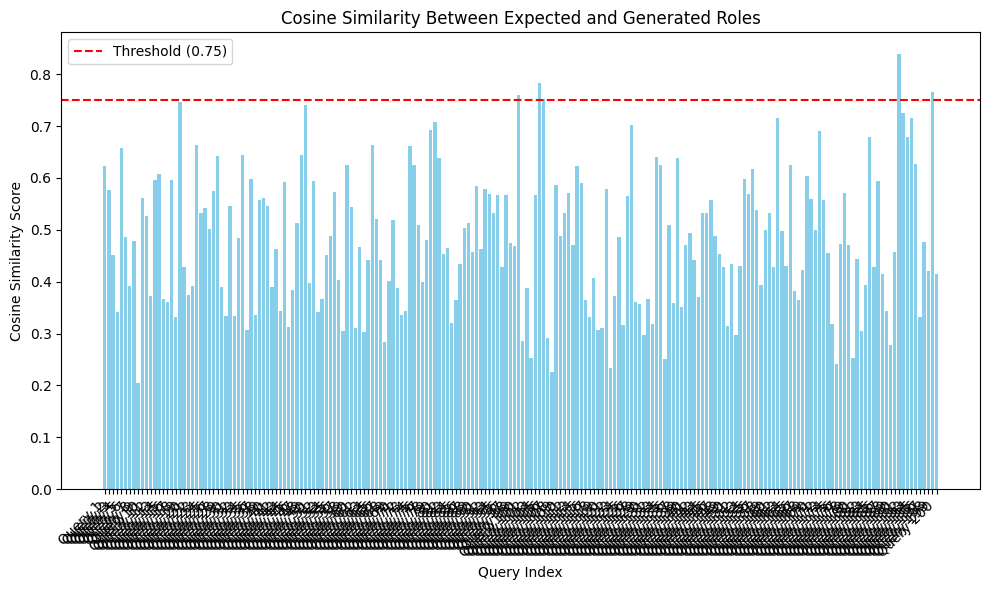

In [ ]:
import matplotlib.pyplot as plt

# Sample Data
queries = [result["query"] for result in predictions]
similarity_scores = [result["cosine_similarity"] for result in predictions]

# Plotting the cosine similarity scores using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(queries)), similarity_scores, color='skyblue')

# Adding labels
plt.xlabel('Query Index')
plt.ylabel('Cosine Similarity Score')
plt.title('Cosine Similarity Between Expected and Generated Roles')
plt.xticks(range(len(queries)), [f"Query {i+1}" for i in range(len(queries))], rotation=45, ha='right')

# Adding a threshold line for reference (e.g., a score of 0.75)
plt.axhline(y=0.75, color='r', linestyle='--', label='Threshold (0.75)')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
import json
import random

# Load your dataset (if required, not used in this version for context-free predictions)
# Replace with actual data loading code if necessary
# df = pd.read_csv('your_dataset.csv')

# Step 1: Fine-Tuning the Model
# Generate training examples
queries = [
    "AI in healthcare", "AI in finance", "Cloud computing", "Blockchain in supply chain",
    "Green technology", "Quantum computing", "Cybersecurity in IoT", "AI in retail",
    "Space technology", "Autonomous vehicles"
]

# Generate examples for fine-tuning
examples = []
for _ in range(10000):
    query = random.choice(queries)
    example = {
        "prompt": f"Query: {query}\nPropose new job roles based on emerging technologies and future trends:",
        "response": "Future roles example"  # Placeholder response for fine-tuning
    }
    examples.append(example)

# Save to JSONL file
with open("training_data.jsonl", "w") as f:
    for example in examples:
        f.write(json.dumps(example) + "\n")

# Load the dataset
dataset = load_dataset("json", data_files={"train": "training_data.jsonl"})

# Load Pre-trained GPT-2 Model and Tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)

# Tokenize Dataset
def tokenize_function(examples):
    tokens = tokenizer(
        examples["prompt"],  # Tokenize prompts
        text_pair=examples["response"],  # Tokenize paired responses
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    tokens["labels"] = tokens["input_ids"].copy()  # Use input_ids as labels
    return tokens

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Fine-Tuning Arguments
training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",
    evaluation_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    max_steps=1000,  # Total number of training steps
    save_steps=500,  # Save the model every 500 steps
    save_total_limit=2,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
)

# Train the Model
trainer.train()

# Save Fine-Tuned Model
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

# Step 2: Use the Fine-Tuned Model for Predictions
generator = pipeline("text-generation", model="./fine_tuned_gpt2", tokenizer=tokenizer, device=0)



Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
500,0.045600
1000,0.004900


In [ ]:
# Function: Predict New Job Roles
def predict_new_job_roles(query):
    # Directly use the query without context
    input_prompt = (
        f"Query: {query}\n"
        "Propose entirely new job roles based on emerging technologies and future trends:"
    )

    # Generate predictions
    response = generator(input_prompt, max_new_tokens=50, num_return_sequences=3)
    return [r['generated_text'] for r in response]

# Example Usage
query = "AI in finance"
predictions = predict_new_job_roles(query)
print(predictions)

query = "I have 4 years of Java Experience with MySQL"
predictions = predict_new_job_roles(query)
print(predictions)


['Query: AI in finance\nPropose entirely new job roles based on emerging technologies and future trends:Future roles example', 'Query: AI in finance\nPropose entirely new job roles based on emerging technologies and future trends:Future roles example', 'Query: AI in finance\nPropose entirely new job roles based on emerging technologies and future trends:Future roles example']
['Query: I have 4 years of Java Experience with MySQL\nPropose entirely new job roles based on emerging technologies and future trends:Future roles example', 'Query: I have 4 years of Java Experience with MySQL\nPropose entirely new job roles based on emerging technologies and future trends:Future roles example', 'Query: I have 4 years of Java Experience with MySQL\nPropose entirely new job roles based on emerging technologies and future trends:Future roles example']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import faiss
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
import json
import random


# Step 1: Text Embedding Preparation
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine all specified text features into a single string per row
text_features = [
    "AISearchDevHaveWorkedWith", "AISearchDevWantToWorkWith", "AISelect",
    "AISent", "AIAcc", "AIBen", "AIToolInterested in Using", "AIToolCurrently Using",
    "AIToolNot interested in Using", "AINextVery different",
    "AINextNeither different nor similar", "AINextSomewhat similar",
    "AINextVery similar", "AINextSomewhat different", 'DevType', 'PlatformWantToWorkWith',
    'Industry', 'LanguageWantToWorkWith', 'ToolsTechWantToWorkWith',
    "LanguageHaveWorkedWith", "LanguageWantToWorkWith", "DatabaseHaveWorkedWith",
    "DatabaseWantToWorkWith", "PlatformHaveWorkedWith", "PlatformWantToWorkWith",
    "WebframeHaveWorkedWith", "WebframeWantToWorkWith", "MiscTechHaveWorkedWith",
    "MiscTechWantToWorkWith", "ToolsTechHaveWorkedWith", "ToolsTechWantToWorkWith",
    "NEWCollabToolsHaveWorkedWith", "NEWCollabToolsWantToWorkWith",
    "OpSysPersonal use", "OpSysProfessional use", "OfficeStackAsyncHaveWorkedWith",
    "OfficeStackAsyncWantToWorkWith", "OfficeStackSyncHaveWorkedWith",
    "OfficeStackSyncWantToWorkWith", "Employment", "OrgSize", "RemoteWork", "SOVisitFreq",
    "SOAccount", "SOPartFreq", "SOComm", "NEWSOSites"
]
df['combined_text_features'] = df[text_features].astype(str).fillna('').agg(' '.join, axis=1)

# Generate embeddings for the combined text features
text_embeddings = embedding_model.encode(df['combined_text_features'].tolist())

# Step 2: Numerical Features Normalization
numerical_features = [
    'WorkExp', 'YearsCode', 'ConvertedCompYearly', 'YearsCodePro'
]

# Handle errors if any arise
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

scaler = StandardScaler()
numerical_embeddings = scaler.fit_transform(df[numerical_features].fillna(0).values)

# Step 3: Combine Text and Numerical Embeddings
row_embeddings = np.hstack((text_embeddings, numerical_embeddings))

# Step 4: Create FAISS Index
dimension = row_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(row_embeddings)

# Step 5: Function to Retrieve Relevant Context
def retrieve_context(query, top_k=3, experience_value=5):
    # Convert query into text and numerical embeddings
    query_text_embedding = embedding_model.encode([query])
    # query_num_features = np.array([[experience_value, 0, 0, 0]])  # Replace with relevant inputs
    query_num_features = np.array([[experience_value, expected_salary, years_in_field, another_feature]])
    query_num_scaled = scaler.transform(query_num_features)

    # Combine text and numerical embeddings
    query_embedding = np.hstack((query_text_embedding, query_num_scaled))

    # Perform FAISS search
    distances, indices = faiss_index.search(query_embedding, top_k)

    # Retrieve rows and combine job roles as context
    retrieved_rows = df.iloc[indices[0]]
    context = " ".join(retrieved_rows['DevType'].tolist())  # Adjust as needed
    return context

# Step 6: Fine-Tuning the Model (Optional - only if training a custom model)
# Save the training data to a JSONL file for further training or fine-tuning
queries = [
    "AI in healthcare", "AI in finance", "Cloud computing", "Blockchain in supply chain",
    "Green technology", "Quantum computing", "Cybersecurity in IoT", "AI in retail",
    "Space technology", "Autonomous vehicles"
]

contexts = df['DevType'].unique().tolist()

roles = [
    "AI Healthcare Strategist", "Cloud Automation Engineer", "Blockchain System Architect",
    "Sustainable Tech Consultant", "Quantum AI Researcher", "IoT Cybersecurity Specialist",
    "Retail Data Scientist", "Space Exploration Analyst", "Autonomous Vehicle Programmer",
    "AI Ethics Consultant", "Digital Twin Specialist", "Metaverse Architect",
    "AI-Powered Climate Analyst", "Neurocomputing Engineer", "Augmented Reality Developer",
    "Synthetic Biology Data Scientist", "AI-Driven Robotics Trainer", "Personalized Education Technologist",
    "Renewable Energy Data Engineer", "AI Trust and Safety Specialist", "Quantum Cryptography Expert",
    "Next-Gen IoT Solution Designer", "AI-Powered Policy Analyst", "Autonomous Drone Fleet Manager",
    "Sustainable Supply Chain Engineer", "Blockchain-Powered Data Analyst", "Holographic Interface Designer",
    "AI-Based Virtual Therapist", "Space Resource Utilization Analyst", "Cybersecurity Threat Hunter",
    "Human-Machine Interaction Designer", "Green Technology Innovator", "AI Governance Specialist",
    "Predictive Maintenance Analyst", "Biometric Security Consultant", "AI-Powered Legal Advisor",
    "AI-Enhanced Content Creator", "Edge Computing Specialist", "Personal AI Trainer",
    "Virtual Reality Safety Officer", "AI-Powered Renewable Energy Forecaster",
    "Advanced AI Model Interpreter", "Data Privacy Strategist", "Emotion AI Developer",
    "Quantum Machine Learning Engineer", "AI-Enabled Urban Planner", "Digital Wellbeing Designer",
    "Energy Optimization AI Consultant", "AI for Accessibility Developer", "Digital Asset Management Specialist"
]


# Generate examples for fine-tuning
examples = []
for _ in range(10000):
    query = random.choice(queries)
    context = random.choice(contexts)
    generated_roles = ", ".join(random.sample(roles, 2))  # Select 2 random roles
    example = {
        "prompt": f"Query: {query}\nContext: {context}\nPropose job roles:",
        "response": generated_roles
    }
    examples.append(example)

# Save to JSONL file
with open("training_data.jsonl", "w") as f:
    for example in examples:
        f.write(json.dumps(example) + "\n")

# Load the dataset
dataset = load_dataset("json", data_files={"train": "training_data.jsonl"})

# Load Pre-trained GPT-2 Model and Tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)

# Tokenize Dataset
def tokenize_function(examples):
    tokens = tokenizer(
        examples["prompt"],  # Tokenize prompts
        text_pair=examples["response"],  # Tokenize paired responses
        padding="max_length",
        truncation=True,
        max_length=512,
    )
    tokens["labels"] = tokens["input_ids"].copy()  # Use input_ids as labels
    return tokens

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Fine-Tuning Arguments
training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",
    evaluation_strategy="no",
    learning_rate=5e-5,
    # per_device_train_batch_size=2,
    # max_steps=1000,  # Total number of training steps
    save_steps=500,  # Save the model every 500 steps
    save_total_limit=2,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
)

# Train the Model
trainer.train()

# Save Fine-Tuned Model
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

# Step 7: Use the Fine-Tuned Model for Predictions
generator = pipeline("text-generation", model="./fine_tuned_gpt2", tokenizer=tokenizer, device=0)


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss


In [ ]:
# RAG Generation: Use retrieval context
def rag_generate(query, top_k=3, experience_value=5, ):
    # Step 1: Retrieve relevant context for the query
    context = retrieve_context(query, top_k=top_k, experience_value=experience_value)

    # Step 2: Combine the query and context into a prompt
    input_prompt = (
        f"Query: {query}\n"
        f"Existing roles and trends: {context}\n"
        "Propose entirely new job roles based on emerging technologies and future trends:"
    )

    # Step 3: Generate predictions from the fine-tuned model
    response = generator(input_prompt, max_length=100, num_return_sequences=3)

    # Step 4: Return the generated roles
    return [r['generated_text'] for r in response]

# Example Usage
query = "AI in finance"
predictions = rag_generate(query)
print(predictions)


In [ ]:
def retrieve_context(query, top_k=3, experience_value=5, expected_salary=0, years_in_field=0, another_feature=0):
    # Convert query into text and numerical embeddings
    query_text_embedding = embedding_model.encode([query])
    query_num_features = np.array([[experience_value, expected_salary, years_in_field, another_feature]])
    query_num_scaled = scaler.transform(query_num_features)

    # Combine text and numerical embeddings
    query_embedding = np.hstack((query_text_embedding, query_num_scaled))

    # Perform FAISS search
    distances, indices = faiss_index.search(query_embedding, top_k)

    # Retrieve rows and combine job roles as context
    retrieved_rows = df.iloc[indices[0]]
    context = " ".join(retrieved_rows['DevType'].tolist())  # Adjust as needed
    return context


In [ ]:
# Example Usage
query = "AI in finance"
predictions = rag_generate(query)
print(predictions)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['Query: AI in finance\nExisting roles and trends: Developer, AI Data scientist or machine learning specialist System administrator\nPropose entirely new job roles based on emerging technologies and future trends:Digital Asset Management Specialist, Personal AI Trainer', 'Query: AI in finance\nExisting roles and trends: Developer, AI Data scientist or machine learning specialist System administrator\nPropose entirely new job roles based on emerging technologies and future trends:Personalized Education Technologist, IoT Cybersecurity Specialist', 'Query: AI in finance\nExisting roles and trends: Developer, AI Data scientist or machine learning specialist System administrator\nPropose entirely new job roles based on emerging technologies and future trends:Sustainable Supply Chain Engineer, Green Technology Innovator']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import faiss
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu
import json
import random

# Step 1: Text Embedding Preparation
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine all specified text features into a single string per row
text_features = [
    "AISearchDevHaveWorkedWith", "AISearchDevWantToWorkWith", "AISelect",
    "AISent", "AIAcc", "AIBen", "AIToolInterested in Using", "AIToolCurrently Using",
    "AIToolNot interested in Using", "AINextVery different",
    "AINextNeither different nor similar", "AINextSomewhat similar",
    "AINextVery similar", "AINextSomewhat different", 'DevType', 'PlatformWantToWorkWith',
    'Industry', 'LanguageWantToWorkWith', 'ToolsTechWantToWorkWith',
    "LanguageHaveWorkedWith", "LanguageWantToWorkWith", "DatabaseHaveWorkedWith",
    "DatabaseWantToWorkWith", "PlatformHaveWorkedWith", "PlatformWantToWorkWith",
    "WebframeHaveWorkedWith", "WebframeWantToWorkWith", "MiscTechHaveWorkedWith",
    "MiscTechWantToWorkWith", "ToolsTechHaveWorkedWith", "ToolsTechWantToWorkWith",
    "NEWCollabToolsHaveWorkedWith", "NEWCollabToolsWantToWorkWith",
    "OpSysPersonal use", "OpSysProfessional use", "OfficeStackAsyncHaveWorkedWith",
    "OfficeStackAsyncWantToWorkWith", "OfficeStackSyncHaveWorkedWith",
    "OfficeStackSyncWantToWorkWith", "Employment", "OrgSize", "RemoteWork", "SOVisitFreq",
    "SOAccount", "SOPartFreq", "SOComm", "NEWSOSites"
]
df['combined_text_features'] = df[text_features].astype(str).fillna('').agg(' '.join, axis=1)

# Generate embeddings for the combined text features
text_embeddings = embedding_model.encode(df['combined_text_features'].tolist())

# Step 2: Numerical Features Normalization
numerical_features = [
    'WorkExp', 'YearsCode', 'ConvertedCompYearly', 'YearsCodePro'
]

# Handle errors if any arise
for col in numerical_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

scaler = StandardScaler()
numerical_embeddings = scaler.fit_transform(df[numerical_features].fillna(0).values)

# Step 3: Combine Text and Numerical Embeddings
row_embeddings = np.hstack((text_embeddings, numerical_embeddings))

# Step 4: Create FAISS Index
dimension = row_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(row_embeddings)

# Step 5: Function to Retrieve Relevant Context
def retrieve_context(query, top_k=3, experience_value=5):
    query_text_embedding = embedding_model.encode([query])
    query_num_features = np.array([[experience_value, 0, 0, 0]])
    query_num_scaled = scaler.transform(query_num_features)
    query_embedding = np.hstack((query_text_embedding, query_num_scaled))
    distances, indices = faiss_index.search(query_embedding, top_k)
    retrieved_rows = df.iloc[indices[0]]
    context = " ".join(retrieved_rows['DevType'].tolist())
    return context

# Generate examples for fine-tuning
queries = [
    "AI in healthcare", "AI in finance", "Cloud computing", "Blockchain in supply chain",
    "Green technology", "Quantum computing", "Cybersecurity in IoT", "AI in retail",
    "Space technology", "Autonomous vehicles"
]

contexts = df['DevType'].unique().tolist()

roles = [
    "AI Healthcare Strategist", "Cloud Automation Engineer", "Blockchain System Architect",
    "Sustainable Tech Consultant", "Quantum AI Researcher", "IoT Cybersecurity Specialist",
    "Retail Data Scientist", "Space Exploration Analyst", "Autonomous Vehicle Programmer",
    "AI Ethics Consultant", "Digital Twin Specialist", "Metaverse Architect",
    "AI-Powered Climate Analyst", "Neurocomputing Engineer", "Augmented Reality Developer",
    "Synthetic Biology Data Scientist", "AI-Driven Robotics Trainer", "Personalized Education Technologist",
    "Renewable Energy Data Engineer", "AI Trust and Safety Specialist", "Quantum Cryptography Expert",
    "Next-Gen IoT Solution Designer", "AI-Powered Policy Analyst", "Autonomous Drone Fleet Manager",
    "Sustainable Supply Chain Engineer", "Blockchain-Powered Data Analyst", "Holographic Interface Designer",
    "AI-Based Virtual Therapist", "Space Resource Utilization Analyst", "Cybersecurity Threat Hunter",
    "Human-Machine Interaction Designer", "Green Technology Innovator", "AI Governance Specialist",
    "Predictive Maintenance Analyst", "Biometric Security Consultant", "AI-Powered Legal Advisor",
    "AI-Enhanced Content Creator", "Edge Computing Specialist", "Personal AI Trainer",
    "Virtual Reality Safety Officer", "AI-Powered Renewable Energy Forecaster",
    "Advanced AI Model Interpreter", "Data Privacy Strategist", "Emotion AI Developer",
    "Quantum Machine Learning Engineer", "AI-Enabled Urban Planner", "Digital Wellbeing Designer",
    "Energy Optimization AI Consultant", "AI for Accessibility Developer", "Digital Asset Management Specialist"
]

examples = []
for _ in range(10000):
    query = random.choice(queries)
    context = random.choice(contexts)
    generated_roles = ", ".join(random.sample(roles, 2))
    example = {
        "prompt": f"Query: {query}\nContext: {context}\nPropose job roles:",
        "response": generated_roles
    }
    examples.append(example)

with open("training_data.json", "w") as f:
    for example in examples:
        f.write(json.dumps(example) + "\n")

# Split the data into train and test sets
with open("training_data.json") as f:
    data = [json.loads(line) for line in f]

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

with open("train_data.json", "w") as f:
    for example in train_data:
        f.write(json.dumps(example) + "\n")
with open("test_data.json", "w") as f:
    for example in test_data:
        f.write(json.dumps(example) + "\n")

# Load datasets for training
dataset = load_dataset("json", data_files={"train": "train_data.json", "test": "test_data.json"})

# Tokenization and training
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("gpt2")

def tokenize_function(examples):
    tokens = tokenizer(
        examples["prompt"], text_pair=examples["response"],
        padding="max_length", truncation=True, max_length=512
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

tokenized_dataset = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./fine_tuned_gpt2",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"  # Disable W&B logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_gpt2")
tokenizer.save_pretrained("./fine_tuned_gpt2")

# Evaluate model accuracy on test data
generator = pipeline("text-generation", model="./fine_tuned_gpt2", tokenizer=tokenizer, device=0)

def evaluate_accuracy(test_data):
    total_bleu_score = 0
    for example in test_data:
        prompt = example["prompt"]
        ground_truth = example["response"]
        generated_response = generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
        bleu_score = sentence_bleu([ground_truth.split()], generated_response.split())
        total_bleu_score += bleu_score
    return total_bleu_score / len(test_data)

accuracy = evaluate_accuracy(test_data)
print("Average BLEU Score (Accuracy):", accuracy)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.028100,0.028111
2,0.027500,0.027334
3,0.027100,0.026935


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use

Average BLEU Score (Accuracy): 0.0010230169898185993


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def evaluate_cosine_similarity(test_data, generator):
    total_similarity = 0
    for example in test_data:
        prompt = example["prompt"]
        ground_truth = example["response"]

        # Generate response using the fine-tuned model
        generated_response = generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]

        # Compute embeddings for ground truth and generated response
        ground_truth_embedding = embedding_model.encode([ground_truth])
        generated_response_embedding = embedding_model.encode([generated_response])

        # Calculate cosine similarity
        similarity = cosine_similarity(ground_truth_embedding, generated_response_embedding)[0][0]
        total_similarity += similarity

    # Average similarity
    return total_similarity / len(test_data)

# Evaluate using the test dataset
cosine_similarity_score = evaluate_cosine_similarity(test_data, generator)
print("Average Cosine Similarity:", cosine_similarity_score)


Average Cosine Similarity: 0.39021723365504296


In [ ]:
prompts = [
    "Query: AI in cloudcomputing",
    "Query: Cloud computing\nContext: Cloud Engineer\nPropose job roles:",
]

for prompt in prompts:
    response = generator(prompt, max_length=100, num_return_sequences=1)
    print("Prompt:", prompt)
    print("Generated Response:", response[0]["generated_text"])
    print("---")


Prompt: Query: AI in cloudcomputing
Generated Response: Query: AI in cloudcomputing
Context: Educator
Propose job roles:Quantum Cryptography Expert, Energy Optimization AI Consultant
---
Prompt: Query: Cloud computing
Context: Cloud Engineer
Propose job roles:
Generated Response: Query: Cloud computing
Context: Cloud Engineer
Propose job roles:Virtual Reality Safety Officer, AI-Powered Climate Analyst
---


In [ ]:
prompts = [
    "Query: Hello Class"
]

for prompt in prompts:
    response = generator(prompt, max_length=100, num_return_sequences=1)
    print("Prompt:", prompt)
    print("Generated Response:", response[0]["generated_text"])
    print("---")


Prompt: Query: Hello Class
Generated Response: Query: Hello Classifier
Context: nan
Propose job roles:Energy Optimization AI Consultant, Digital Twin Specialist
---
